<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/02_CNN/CNN03_Grad-CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Prepare the Enviroment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-70ce5fb6-d739-382e-8fbc-4e374988c4b7)


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"OpenCV {cv.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
NumPy 1.21.5
OpenCV 4.1.2
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


# 2) Load the model to inspect

In [ ]:
load_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
load_model.summary()

553476096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# 3) Adapt the base model
The last layer in current model currently consists of the output layer and the softmax activation. To perform Grad-CAM, we have to separate it in order to get raw (logit) predict score

In [ ]:
load_model.layers[-1].activation

<function keras.activations.softmax>

In [ ]:
def alter_model_for_GradCAM(model, last_conv_layer_name):
  #1) Get the output from the last convolutional layer
  last_conv_output = model.get_layer(last_conv_layer_name).output

  #2) Separate the original output layer into one prediction layer and one activation softmax layer
  ### 2.1) Copy weight of the original output layers
  old_weights = [x.numpy() for x in model.layers[-1].weights]
  ### 2.2) Copy configuration of the original layer and change where necessary
  new_config = model.layers[-1].get_config()
  new_config['activation'] = tf.keras.activations.linear    #layer's activation changed
  new_config['name'] = 'pred_linear'                           #layer's name changed
  ### 2.3 Create two new layers (linear prediction and softmax)
  out_linear = tf.keras.layers.Dense(**new_config)(model.layers[-2].output)
  out_softmax = tf.keras.activations.softmax(out_linear)

  #3) Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model(inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output])
  new_model.layers[-2].set_weights(old_weights) # Assign old weight pred_linear layer 

  return new_model

In [ ]:
new_model = alter_model_for_GradCAM(load_model, 'block5_pool')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
print(f"Input layer : {new_model.input_names}")
print(f"Output layer: {new_model.output_names}")

Input layer : ['input_1']
Output layer: ['tf.nn.softmax', 'pred_linear', 'block5_pool']


# 4) Custom ImageNet's decode_predictions

In [ ]:
def my_image_decode_predictions(preds, top=5):
  """
  This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  preds (numpy array) : a batch of ImageNet's prediction output (with softmax activation)
    top (int) : only decode 'top' class with maximum score
  Return a tuple of:
    output[0] : a dict of {class_index:class_name} regarding ImageNet dataset
    output[1] : a 4D tuple of (class_index, class_name, class_description, score)
  """
  if len(preds.shape) != 2 or preds.shape[1] != 1000:
    raise ValueError(' `decode_predictions` expects'
                           'a batch of predictions'
                           '(i.e. a 2D array of shape (samples, 1000)).'
                           'Found array with shape: '+str(preds.shape))

  
  import json

  CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
  fpath = tf.keras.utils.get_file('imagenet_class_index.json', CLASS_INDEX_PATH,
                                  cache_subdir='models',
                                  file_hash='c2c37ea517e94d9795004a39431a14cb')
  
  with open(fpath) as f:
    CLASS_INDEX = json.load(f)
    CLASS_INDEX = dict( zip([ int(i) for i in CLASS_INDEX.keys()],CLASS_INDEX.values() ) )

  results = []
  for pred in preds:
    top_indices = pred.argsort()[-top:][::-1]
    result = [ (i,) + tuple( CLASS_INDEX[i]) + (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[-1], reverse=True)
    results.append(result)

  return CLASS_INDEX, results

In [ ]:
# load a test image from Internet
!wget -O image.jpg 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'

--2022-03-06 08:19:03--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229955 (225K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 224.57K  --.-KB/s    in 0.009s  

2022-03-06 08:19:03 (24.9 MB/s) - ‘image.jpg’ saved [229955/229955]



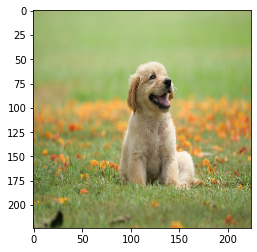

In [ ]:
#load an image as PIL.Image.image
img_path = './image.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))

# Covert PIL Image to NumPy ndarray
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype(np.uint8)

plt.imshow(img)
plt.show()

In [ ]:
# Preprocess the input image
img_preprocess = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img, axis=0))

print( f"img_preprocess shape={img_preprocess.shape}, dtype={img_preprocess.dtype}")

img_preprocess shape=(1, 224, 224, 3), dtype=float32


Compre the load model and new model to make sure that they produce identical results

In [ ]:
#Original Model
out_softmax = load_model.predict(img_preprocess)

imagenet_dict, result = my_image_decode_predictions(out_softmax ,top=10)
result

49152/35363 [=========================================] - 0s 0us/step


[[(267, 'n02113799', 'standard_poodle', 0.6753279),
  (266, 'n02113712', 'miniature_poodle', 0.26393384),
  (265, 'n02113624', 'toy_poodle', 0.025148204),
  (181, 'n02093647', 'Bedlington_terrier', 0.02137482),
  (219, 'n02102318', 'cocker_spaniel', 0.004134437),
  (207, 'n02099601', 'golden_retriever', 0.0020418034),
  (222, 'n02104029', 'kuvasz', 0.0009701642),
  (852, 'n04409515', 'tennis_ball', 0.0007033871),
  (202, 'n02098105', 'soft-coated_wheaten_terrier', 0.00053886446),
  (208, 'n02099712', 'Labrador_retriever', 0.0005093698)]]

In [ ]:
# Modified Model
out_softmax,out_liner,_ = new_model.predict(img_preprocess)

imagenet_dict, result = my_image_decode_predictions(out_softmax ,top=10)
result

[[(267, 'n02113799', 'standard_poodle', 0.6753279),
  (266, 'n02113712', 'miniature_poodle', 0.26393384),
  (265, 'n02113624', 'toy_poodle', 0.025148204),
  (181, 'n02093647', 'Bedlington_terrier', 0.02137482),
  (219, 'n02102318', 'cocker_spaniel', 0.004134437),
  (207, 'n02099601', 'golden_retriever', 0.0020418034),
  (222, 'n02104029', 'kuvasz', 0.0009701642),
  (852, 'n04409515', 'tennis_ball', 0.0007033871),
  (202, 'n02098105', 'soft-coated_wheaten_terrier', 0.00053886446),
  (208, 'n02099712', 'Labrador_retriever', 0.0005093698)]]

# 5) Grad-CAM for CNN

In [ ]:
def my_CNN_GradCAM( model, in_img, class_index):
  # Covert from numpy to tensor
  in_img = tf.cast(in_img ,tf.float32)

  #Computer the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model(in_img)
    one_class_score = y_linear[...,class_index]
  gradient = tape.gradient( one_class_score, last_conv_activation) #tensor size (1,7,7,512)

  #Compute a vector of alphas (one alpha value is one weight for one 2D feature map) by averaging each 2D gradient
  gradient = gradient.numpy().squeeze(axis=0) #numpy shape (7,7,512)
  alpha = np.mean(gradient ,axis=(0,1)) #numpy shape=(512,)

  #Compute the weighted-sum heatmap
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0) #numpy shape (1,7,7,512) -> shape (7,7,512)
  heatmap = np.dot(last_conv_activation,alpha) #numpy shape=(7,7)

  # Don't highlight any pixels with negative gradients (= apply ReLU)
  heatmap = np.maximum(0 ,heatmap)

  return heatmap

Test visualizing Grad-CAM for ImageNet Classes with the 20 highest Predict scores

In [ ]:
#Get prediction with higest scores
top=20
_, top_results = my_image_decode_predictions(out_softmax ,top=top)

# Extract 0-based class indices
top_index = [tp[0] for tp in top_results[0] ]

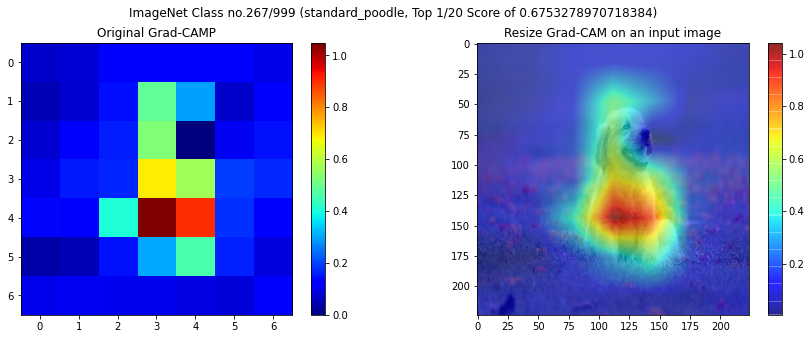

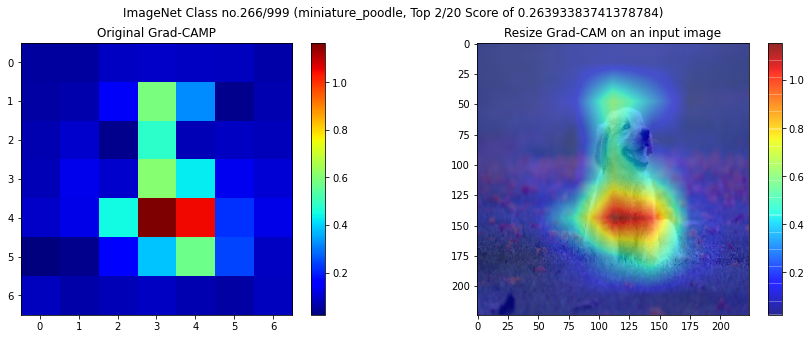

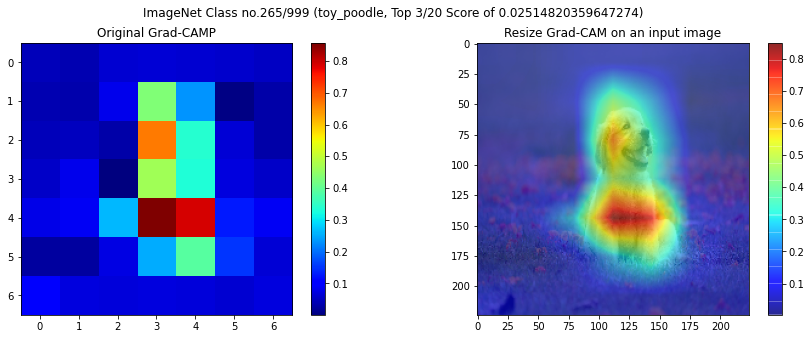

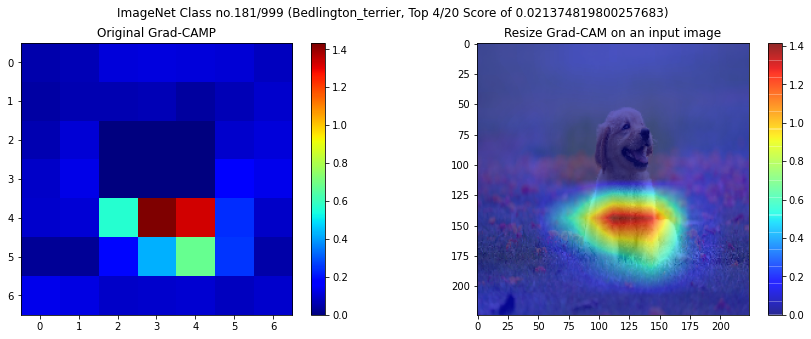

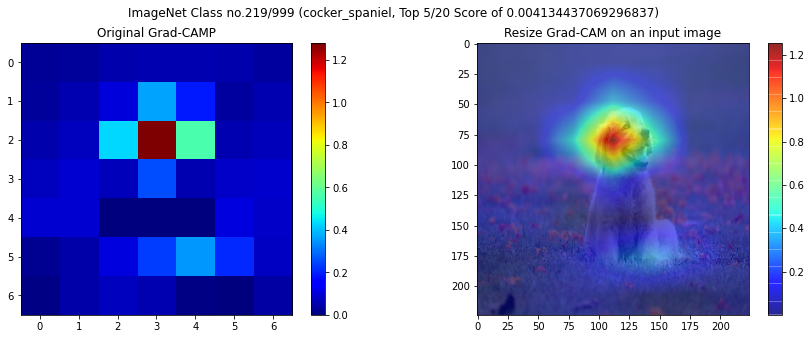

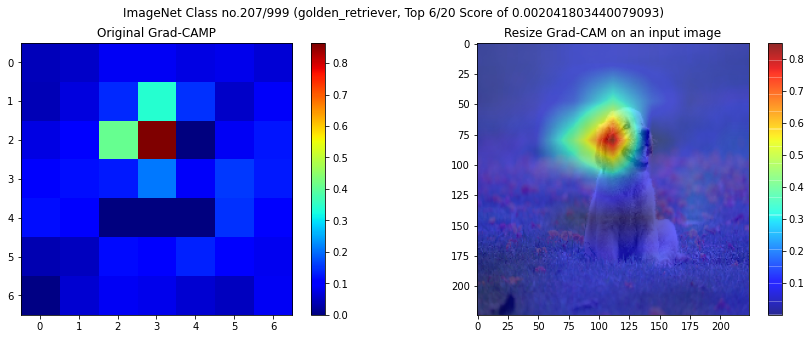

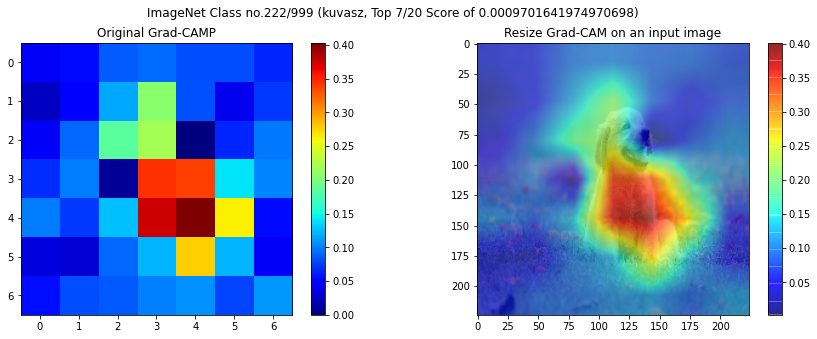

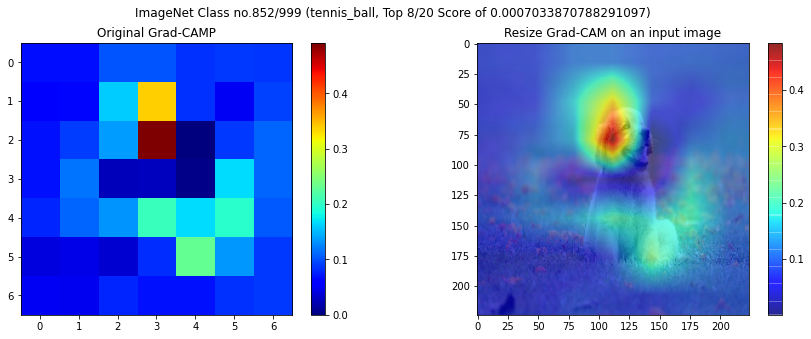

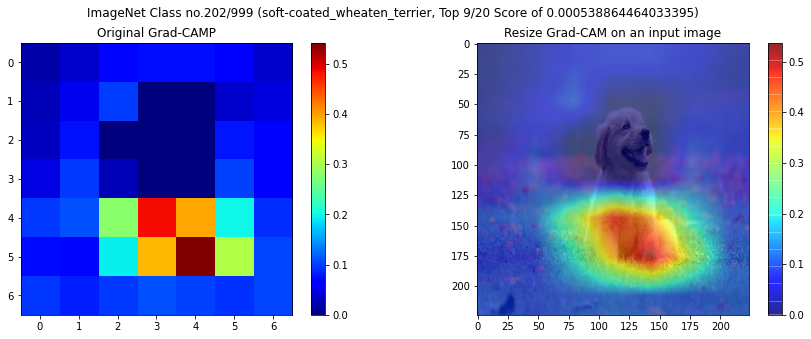

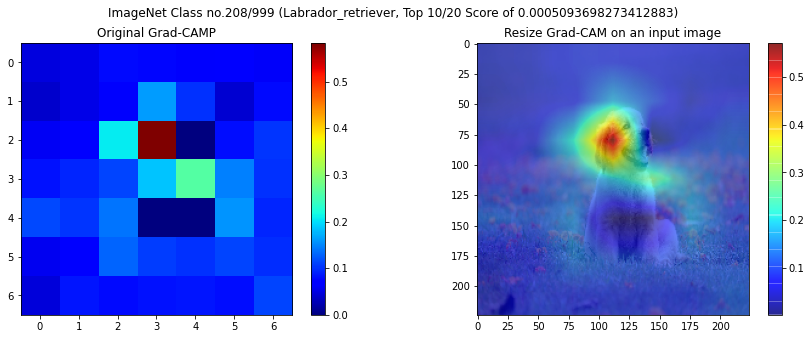

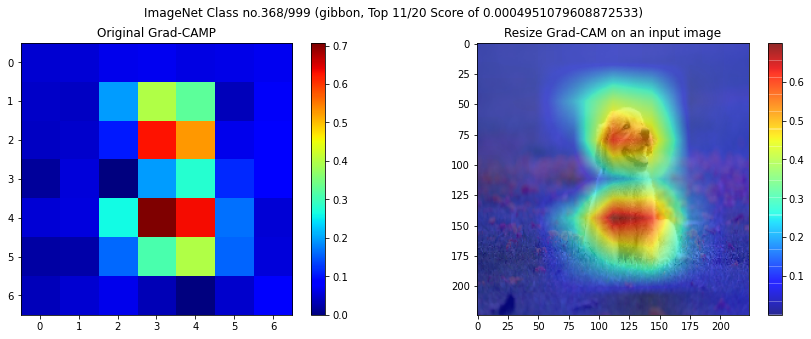

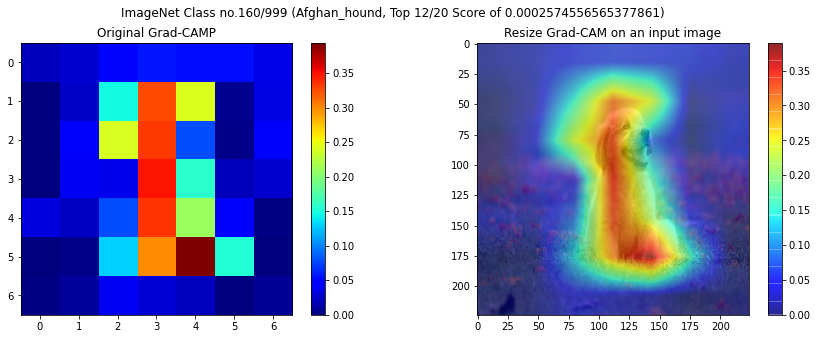

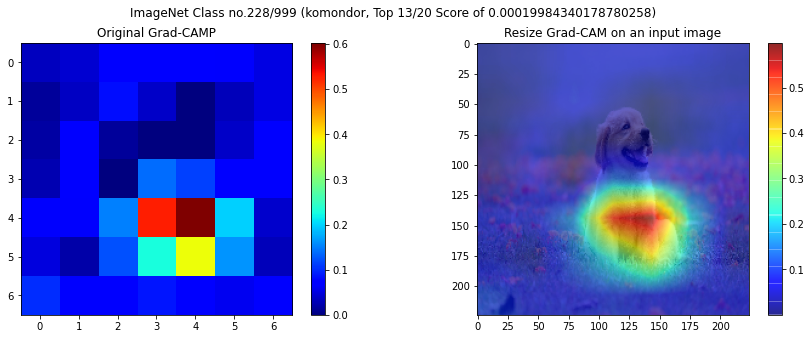

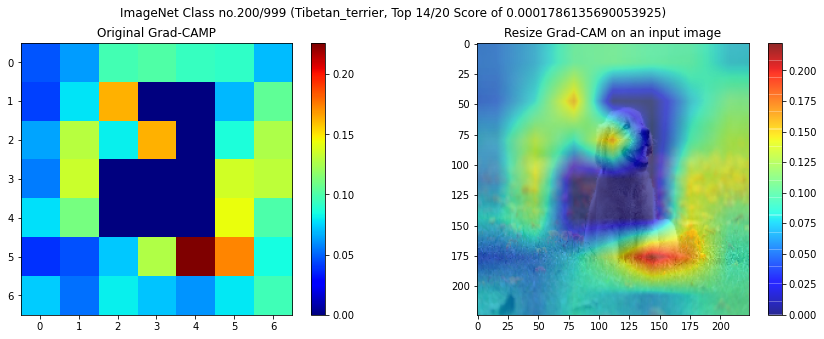

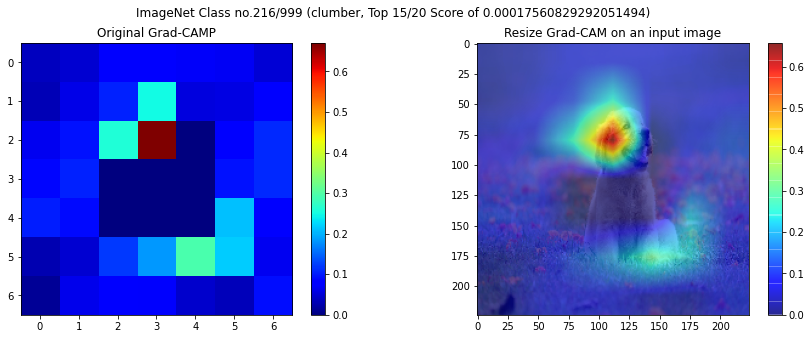

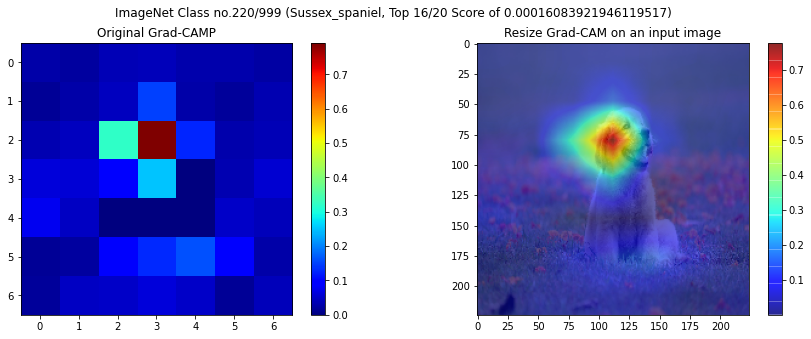

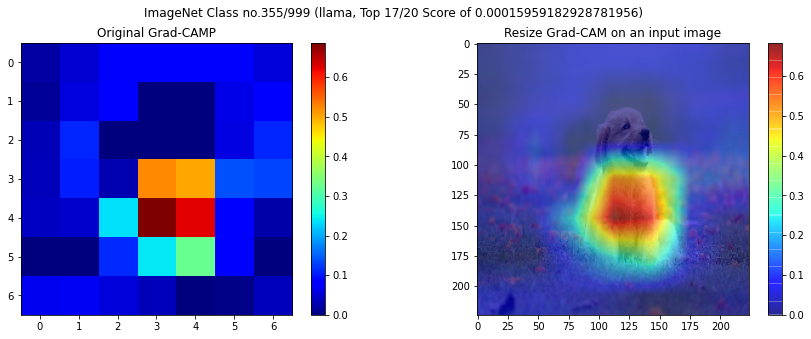

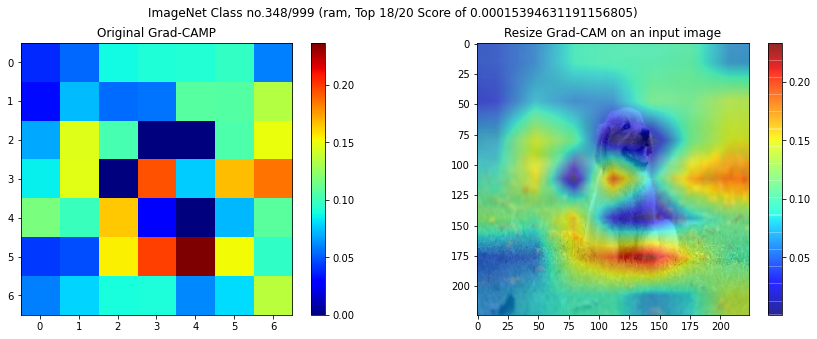

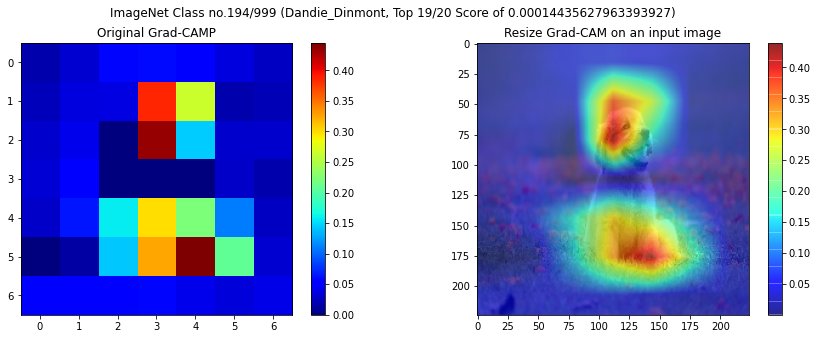

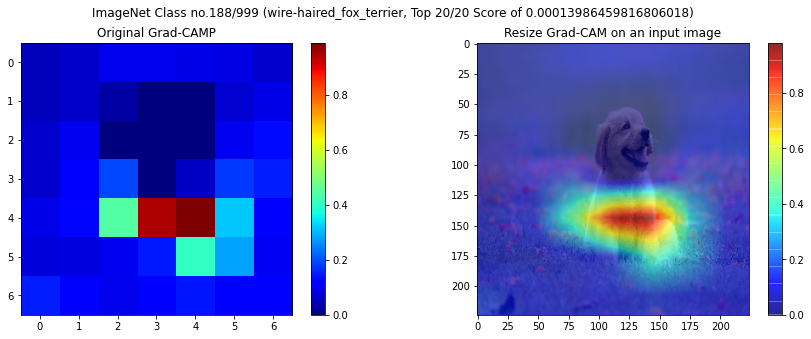

In [ ]:
for i,c in enumerate(top_index):
  heatmap = my_CNN_GradCAM(new_model, #the CNN model
                           img_preprocess, # input of the model
                           c #the 0-based index of output class to compute and visualize Brad-CAM
                           )
  #Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = f"{imagenet_dict[c][-1]}, Top {i+1}/{top} Score of {out_softmax[...,c].squeeze()}"
  fig.suptitle(f"ImageNet Class no.{c}/{len(imagenet_dict)-1} ({class_desc})")
  # Visualize the Original Heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title('Original Grad-CAMP')
  im = ax.imshow( heatmap ,cmap='jet')
  plt.colorbar(im, ax=ax)

  #Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title('Resize Grad-CAM on an input image')
  ax.imshow(img)
  alpha = 0.6
  im = ax.imshow(cv.resize( heatmap, img.shape[:2]), cmap='jet', alpha=alpha )
  plt.colorbar(im, ax=ax)

  plt.show()